## Setup

### Importing Dependencies

In [1]:
# Torch for training models
import torch
import torch.nn as nn

# Mathematical libraries
import numpy as np
import cmath
from scipy import stats
import dcor

# Visualization and data saving
from tqdm import tqdm, trange
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle

# GPT-2 Tokenizer
from transformers import GPT2Tokenizer

# Transformer model class
from transformer_model import TransformerModel

# Submodel classes
from sub_models import EmbeddingModel, AttentionModel

# Tuned Lens model class
from tuned_lens import TunedLens

# Dataset class
from transformer_dataset import SentihoodDataset

# For GPT-2 embeddings
from utils import GPT2EmbeddingUtility

### Fixing Random Seed for Reproducibility

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

### Defining Project Directories

In [3]:
proj_dir = "./QLens/" # Personalize if needed

data_dir = proj_dir + "Datasets/"

model_dir = proj_dir + "Model_Checkpoints/"
lens_dir = proj_dir + "Lens_Checkpoints/"

figures_dir = proj_dir + "Figures/"
atten_figures_dir = proj_dir + "Figures/Attention_Layer/"
mlp_figures_dir = proj_dir + "Figures/MLP_Layer/"

## Loading Sentihood Data

In [4]:
# Loading saved Train and Test splits

train_path = data_dir + 'train.pickle'
test_path = data_dir + 'test.pickle'

with open(train_path, 'rb') as train_file:
    train_dict = pickle.load(train_file)

with open(test_path, 'rb') as test_file:
    test_dict = pickle.load(test_file)

In [5]:
# Resolving train and test splits into input/output segments

X_train = train_dict['X']
y_train = train_dict['y']

X_test = test_dict['X']
y_test = test_dict['y']

## Loading Base Transformer Model

In [6]:
# Instantiating the Transfomer model's architecture

# Selecting the training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GPT-2 Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': '<PAD>', 'cls_token': '<CLS>'})

# Hyperparameters
d_embedding = 768   # Dimensionality of initial GPT-2 embeddings
d_model = 128       # Dimension of the model's feature space
num_heads = 4       # Number of attention heads
d_ff = 512          # Dimension of the inner MLP layer
dropout_rate = 0.1  # Dropout rate

model = TransformerModel(d_embedding = d_embedding,
                         d_model = d_model,
                         dim_feedforward = d_ff,
                         num_heads = num_heads,
                         dropout_rate = dropout_rate,
                         tokenizer_len = len(tokenizer))
model.to(device)

TransformerModel(
  (word_embeddings_layer): Embedding(50259, 768)
  (positional_embeddings_layer): Embedding(1024, 768)
  (compression): Linear(in_features=768, out_features=128, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (w1): Linear(in_features=128, out_features=512, bias=True)
  (attention_dropout): Dropout(p=0.1, inplace=False)
  (w2): Linear(in_features=512, out_features=128, bias=True)
  (attention_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (mlp_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (w1_dropout): Dropout(p=0.1, inplace=False)
  (w2_dropout): Dropout(p=0.1, inplace=False)
  (classification_layer): Linear(in_features=128, out_features=2, bias=True)
)

In [7]:
# Loading model state dict
model_checkpoint = torch.load(os.path.join(model_dir, 'model_checkpoint.pth'))
model_state_dict = model_checkpoint['model_state_dict']

model.load_state_dict(model_state_dict)
model.to(device)

TransformerModel(
  (word_embeddings_layer): Embedding(50259, 768)
  (positional_embeddings_layer): Embedding(1024, 768)
  (compression): Linear(in_features=768, out_features=128, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (w1): Linear(in_features=128, out_features=512, bias=True)
  (attention_dropout): Dropout(p=0.1, inplace=False)
  (w2): Linear(in_features=512, out_features=128, bias=True)
  (attention_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (mlp_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (w1_dropout): Dropout(p=0.1, inplace=False)
  (w2_dropout): Dropout(p=0.1, inplace=False)
  (classification_layer): Linear(in_features=128, out_features=2, bias=True)
)

## Loading Tuned Lenses and Preparing Submodels

In [8]:
# Instanitating embedding lens and model architectures
embedding_lens = TunedLens(d_model, model.mlp_norm, model.classification_layer, 'embedding').to(device)
embedding_model = EmbeddingModel(model.compression, device)

# Loading the embedding lens state dict
embedding_lens_checkpoint = torch.load(os.path.join(lens_dir, 'embedding_lens_checkpoint.pth'))
embedding_lens_state_dict = embedding_lens_checkpoint['model_state_dict']

embedding_lens.load_state_dict(embedding_lens_state_dict)
embedding_lens.to(device)

TunedLens(
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (unembedding): Linear(in_features=128, out_features=2, bias=True)
)

In [9]:
# Instanitating attention lens and model architectures
attention_lens = TunedLens(d_model, model.mlp_norm, model.classification_layer, 'attention').to(device)
attention_model = AttentionModel(model.compression, model.attention, device)

# Loading attention lens state dict
attention_lens_checkpoint = torch.load(os.path.join(lens_dir, 'attention_lens_checkpoint.pth'))
attention_lens_state_dict = attention_lens_checkpoint['model_state_dict']

attention_lens.load_state_dict(attention_lens_state_dict)
attention_lens.to(device)

TunedLens(
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (unembedding): Linear(in_features=128, out_features=2, bias=True)
)

## Creating Unitaries

In [10]:
embeddings = GPT2EmbeddingUtility(tokenizer)

"""
get_intermediate_probs() returns intermediate probabilities extracted by Tuned Lens

Args:
    dataset (SentihoodDataset): Dataset containing instance
                                to derive probabilites from
    example_id (int): Index of dataset instance to derive probabilites from
    lens (TunedLens): Tuned Lens used to extract probabilities
    position (str): Either 'embedding' or 'attention'; specifies which submodel's
                    output should be passed to the inputted Tuned Lens

Returns:
    indermediate_probs (torch.Tensor): intermediate probabilities extracted by
                                       the Tuned Lens
"""
def get_intermediate_probs(dataset, example_id, lens, position):
  # Deriving input tokens and their GPT-2 embeddings
  input_ids = dataset[example_id]['input_ids'].to(device)
  gpt2_embeddings = embeddings.get_embeddings(input_ids).to(device)

  # Determining which submodel to use based on inputted position
  if position == 'embedding':
    embedding = embedding_model(gpt2_embeddings)
    intermediate_logits = lens(embedding)
  elif position == 'attention':
    pad_mask = torch.zeros(gpt2_embeddings.shape[1], dtype = torch.bool).unsqueeze(dim = 0).to(device)
    post_attention = attention_model(gpt2_embeddings, pad_mask)
    intermediate_logits = lens(post_attention)

  # Normalizing logits into probabilities via softmax
  intermediate_probs = nn.functional.softmax(intermediate_logits, dim = -1)

  return intermediate_probs


"""
get_final_probs() computes output probabilities from pretrained Transformer model

Args:
    dataset (SentihoodDataset): Dataset containing instance
                                to derive probabilites from
    example_id (int): Index of dataset instance to derive probabilites from

Returns:
    final_probs (torch.Tensor): output probabilities for instance stemming from
                                original model
"""
def get_final_probs(dataset, example_id):
  # Deriving input tokens and their GPT-2 embeddings
  input_ids = dataset[example_id]['input_ids'].to(device)
  gpt2_embeddings = embeddings.get_embeddings(input_ids).to(device)

  # Generating simple key padding mask
  pad_mask = torch.zeros(gpt2_embeddings.shape[1], dtype = torch.bool).unsqueeze(dim = 0).to(device)

  # Passing GPT-2 embeddings through model to obtain class probabilities
  final_probs = model(gpt2_embeddings, pad_mask)

  return final_probs

"""
construct_state_ket() creates a state vector to represent the input
classification probabilities, where each element is the probability amplitude
(square root of the probability) for a class.

Args:
    probs_tensor (torch.Tensor): A PyTorch tensor containing the class
                                 probabilities output by the model. It is
                                 expected to have shape (1, N) or (N), where N
                                 is the number of classes.

Returns:
    ket (numpy.ndarray): Quantum ket with representing input probabilities.
"""
def construct_state_ket(probs_tensor):
  probs_vector = probs_tensor.squeeze().detach().cpu().numpy()
  ket = np.sqrt(probs_vector)

  return ket

"""
get_reflecting_plane_normal_vec() calculates normalized Householder vector
that reflects ket phi_0 onto ket phi_1.

Args:
    phi_0 (numpy.ndarray): The initial ket
    phi_1 (numpy.ndarray): The target ket that phi_1 is to be reflected onto.

Returns:
    numpy.ndarray: The normalized Householder vector (normal vector to the
                   reflecting plane)
"""
def get_reflecting_plane_normal_vec(phi_0, phi_1):
  return ((phi_1 - phi_0) / np.linalg.norm((phi_1 - phi_0)))

"""
get_unitary() creates a unitary Householder transformation that maps the first
state vector to the second up to a global phase.

Args:
    phi_0 (numpy.ndarray): The initial state vector
    phi_1 (numpy.ndarray): The target state vector

Returns:
    unitary (numpy.ndarray): The Householder unitary matrix ($U = I - 2vv^T$)
                             which performs the reflection.
    reflecting_plane_normal_vec (numpy.ndarray): The Householder reflection
                                                 vector used to define the
                                                 reflection.
"""
def get_unitary(phi_0, phi_1):
  identity = np.identity(phi_0.size)

  reflecting_plane_normal_vec = get_reflecting_plane_normal_vec(phi_0, phi_1)
  outer_product = np.outer(reflecting_plane_normal_vec, reflecting_plane_normal_vec)

  unitary = identity - (2 * outer_product)

  return unitary, reflecting_plane_normal_vec


"""
get_unitary_from_ex() creates a unitary Householder transformation and its
relfection vector that maps an initial state vector (phi_0) to a
target state vector (phi_1) for a specific dataset example.

Args:
    dataset (SentihoodDataset): Dataset containing the instance to analyze.
    example_id (int): Index of the dataset instance to derive state vectors from.
    pos_1 (str): Either 'embedding' or 'attention'; specifies the output of layer
                 from which the initial state vector is derived.
    pos_2 (str, optional): Either 'attention' or 'mlp' (default); specifies the
                           layer/position for the target state.
    verbose (bool, optional): If True, prints the initial and target state vectors

Returns:
    unitary (numpy.ndarray): The Householder unitary matrix that maps the initial
                             instance-derived state vector to its target.
    hh_vec (numpy.ndarray): The normalized Householder vector of the transformation.
"""
def get_unitary_from_ex(dataset, example_id, pos_1, pos_2 = 'mlp', verbose = False):

  # Obtaining intermediate probabilities
  if pos_1 == 'embedding':
    phi_0_probs = get_intermediate_probs(dataset, example_id, embedding_lens, pos_1)
    if pos_2 == 'attention':
      phi_1_probs = get_intermediate_probs(dataset, example_id, attention_lens, pos_2)
    else:
      phi_1_probs = get_final_probs(dataset, example_id)
  elif pos_1 == 'attention':
    phi_0_probs = get_intermediate_probs(dataset, example_id, attention_lens, pos_1)
    phi_1_probs = get_final_probs(dataset, example_id)

  # Constructing state vectors
  phi_0 = construct_state_ket(phi_0_probs)
  phi_1 = construct_state_ket(phi_1_probs)

  if verbose:
    print(f"Phi_0: \n{phi_0}")
    print(f"Phi_1: \n{phi_1}")
    print("")

  # Obtaining unitary and Householder vector
  unitary, hh_vec = get_unitary(phi_0, phi_1)

  # Checking to ensure unitary appropriately maps initial state vector to target
  if not np.allclose((unitary @ phi_0), phi_1, atol = 0.01):
    print(f"\nUnitary Constructed Incorrectly\nUnitary @ Phi_0: {(unitary @ phi_0)}\nPhi_1: {phi_1}")

  return unitary, hh_vec

In [11]:
# Obtaining unitaries and Householder vectors for attention and MLP layers
attention_unitaries = []
attention_hh_vecs  = []

mlp_unitaries = []
mlp_hh_vecs  = []

unitary_dataset = SentihoodDataset(X_test, y_test, tokenizer)

for i in tqdm(range(len(unitary_dataset)), desc = 'Unitary Construction'):

  attention_unitary, attention_hh_vec = get_unitary_from_ex(unitary_dataset, i, 'embedding', 'attention')
  mlp_unitary, mlp_hh_vec = get_unitary_from_ex(unitary_dataset, i, 'attention', 'mlp')

  attention_unitaries.append(attention_unitary)
  attention_hh_vecs.append(attention_hh_vec)

  mlp_unitaries.append(mlp_unitary)
  mlp_hh_vecs.append(mlp_hh_vec)

Unitary Construction: 100%|██████████| 214/214 [00:01<00:00, 211.22it/s]


In [12]:
"""
frobenius_cosine() computes the similarity between two matrices using the
Frobenius cosine method.

Args:
    A (numpy.ndarray): The first matrix
    B (numpy.ndarray): The second matrix

Returns:
    float: The Frobenius cosine similarity between A and B
"""
def frobenius_cosine(A, B):
    frobenius_inner_product = np.trace(A.T @ B)

    return (frobenius_inner_product / (np.linalg.norm(A, 'fro') * np.linalg.norm(B, 'fro')))

"""
get_matrix_sims() computes the Frobenius cosine similarity for all distinct
pairs of matricies within a given sample set.

Args:
    matrices (list of numpy.ndarray): A list of matrices for which pairwise
                                      similarities are to be calculated.

Returns:
    matrix_sims (list of float): A list of the Frobenius cosine similarity
                                 values for all unique pairs from the
                                 input list.
"""
def get_matrix_sims(matrices):
    matrix_sims = []

    for j in range(len(matrices)):
        A = matrices[j]
        for k in range(j + 1, len(matrices)):
            B = matrices[k]
            matrix_sims.append(frobenius_cosine(A, B))

    return matrix_sims

"""
create_sims_histogram() visualizes matrix similarities in a histogram

Args:
    sim_list (list of numpy.ndarray): A list of parwise matrix similarities to visualize
    bins (int): Number of bins in output histogram
    plt_title (str): Title of resulting histogram
    save_dir (str): Directory to save file
    file_name (str): Name of histogram save file

Returns:
    mean_sim (float): Mean pairwise similaritity of matricies in sim_list
"""
def create_sims_histogram(sim_list, bins, plt_title, save_dir, file_name):
    # Calculating mean pairwise similarity
    mean_sim = sum(sim_list) / len(sim_list)

    # Creating plot
    plt.figure(figsize=(10, 6))
    plt.hist(sim_list, bins = bins, edgecolor = 'black', alpha = 0.8, label='Attention Unitary Similarities')

    plt.title(plt_title, fontsize=16)
    plt.xlabel('Frobenius Similarity Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Vectical line indicating mean pairwise similarity
    plt.axvline(mean_sim, color='red', linestyle='dashed', linewidth=2, label=f'Mean Similarity: {mean_sim:.2f}')
    plt.legend()

    plt.xlim(-1, 1)
    plt.savefig(save_dir + file_name)
    plt.show()

    return mean_sim

"""
create_vec_scatter() visualizes vectors in a scatter plot

Args:
    vec_list (list of numpy.ndarray): A list of vectors to visualize
    plt_title (str): Title of resulting plot
    save_dir (str): Directory to save file
    file_name (str): Name of plot save file
    delta_phi_area (bool): Specifies whether locus of possible delta phi vectors
                           is to be shaded for comparision. Defults to false.
"""
def create_vec_scatter(vec_list, plt_title, save_dir, file_name, delta_phi_area = False):
    # Obtaining vector x and y components to plot
    vec_list_x = []
    vec_list_y = []

    for vec in vec_list:
        vec_list_x.append(vec.squeeze()[0])
        vec_list_y.append(vec.squeeze()[1])

    # Creating plot
    plt.figure(figsize=(8, 8))
    scatter_plot = plt.scatter(vec_list_x, vec_list_y, c = 'blue', alpha = 0.8, zorder = 3, label = 'Vector')

    if delta_phi_area:

        if False:
            # Checking if all scatter plot vectors are in the locus

            vecs = [np.asarray(v).squeeze() for v in vec_list]
            xs = np.array([float(v[0]) for v in vecs])
            ys = np.array([float(v[1]) for v in vecs])

            inA = xs**2 + (ys + 1.0)**2 <= 1.0
            # circle B: center (1, 0)
            inB = (xs - 1.0)**2 + ys**2 <= 1.0
            # circle C: center (-1, 0)
            inC = (xs + 1.0)**2 + ys**2 <= 1.0
            # circle D: center (0, 1)
            inD = xs**2 + (ys - 1.0)**2 <= 1.0

            # membership in the locus = (A and B) or (C and D)
            in_locus = (inA & inB) | (inC & inD)

            # Are all vectors inside?
            all_inside = bool(np.all(in_locus))
            # Indices of points outside
            outside_indices = np.nonzero(~in_locus)[0].tolist()

            print(len(outside_indices))

        # Creating locus of all valid delta phi vectors, which is the union of multiple circles
        x_min, x_max = -1.1, 1.1
        y_min, y_max = -1.1, 1.1
        res = 800
        x = np.linspace(x_min, x_max, res)
        y = np.linspace(y_min, y_max, res)
        X, Y = np.meshgrid(x, y)

        # Circle equations:
        circA = X**2 + (Y + 1)**2 <= 1
        circB = (X - 1)**2 + Y**2 <= 1
        circC = (X + 1)**2 + Y**2 <= 1
        circD = X**2 + (Y - 1)**2 <= 1

        # Intersections
        intersection_mask_AB = circA & circB
        intersection_mask_CD = circC & circD

        intersection_mask_AB = intersection_mask_AB.astype(float)
        intersection_mask_CD = intersection_mask_CD.astype(float)

        # Ploting the shaded intersection region
        plt.contourf(X, Y, intersection_mask_AB, levels=[0.5, 1.0], alpha=0.35, colors='orange', zorder=1)
        plt.contourf(X, Y, intersection_mask_CD, levels=[0.5, 1.0], alpha=0.35, colors='orange', zorder=1)

        # Drawing circle outlines for clarity
        theta_AC = np.linspace(0, 0.5 * np.pi, 400)

        circleA_x = np.cos(theta_AC)
        circleA_y = np.sin(theta_AC) - 1

        circleC_x = np.cos(theta_AC) - 1
        circleC_y = np.sin(theta_AC)

        theta_BD = np.linspace(np.pi, 1.5 * np.pi, 400)

        circleB_x = np.cos(theta_BD) + 1
        circleB_y = np.sin(theta_BD)

        circleD_x = np.cos(theta_BD)
        circleD_y = np.sin(theta_BD) + 1

        plt.plot(circleA_x, circleA_y, linewidth = 1.5, linestyle = '-', c = 'black', zorder = 2)
        plt.plot(circleB_x, circleB_y, linewidth = 1.5, linestyle = '-', c = 'black', zorder = 2)
        plt.plot(circleC_x, circleC_y, linewidth = 1.5, linestyle = '-', c = 'black', zorder = 2)
        plt.plot(circleD_x, circleD_y, linewidth = 1.5, linestyle = '-', c = 'black', zorder = 2)

        orange_patch = mpatches.Patch(color='orange', alpha=0.35, label='Locus of Possibilities')
        plt.legend(handles=[scatter_plot, orange_patch], loc='upper right', fontsize=10)

    plt.title(plt_title, fontsize=16)
    plt.xlabel('Positive Sentiment Probability Amplitude', fontsize=12)
    plt.ylabel('Negative Sentiment Probability Amplitude', fontsize=12)
    plt.grid(axis='both', linestyle='--', alpha=0.6)

    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)

    plt.savefig(save_dir + file_name)
    plt.show()

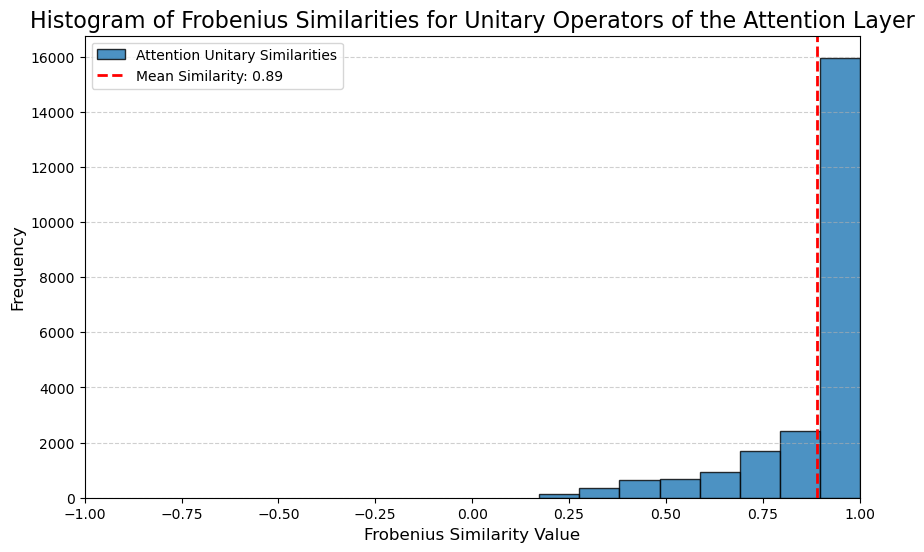

In [13]:
# Finding Frobenious cosine similarities for all operators pairs of the attention layer
attention_unitary_sims = get_matrix_sims(attention_unitaries)

# Obtaining the mean similarity of the unitary operators and creating a histogram to visualize similarities
mean_attention_unitary_sims = create_sims_histogram(sim_list = attention_unitary_sims,
                                                    bins = 8,
                                                    plt_title = 'Histogram of Frobenius Similarities for Unitary Operators of the Attention Layer',
                                                    save_dir = atten_figures_dir,
                                                    file_name = 'attention_unitary_frobenius_similarities.png')

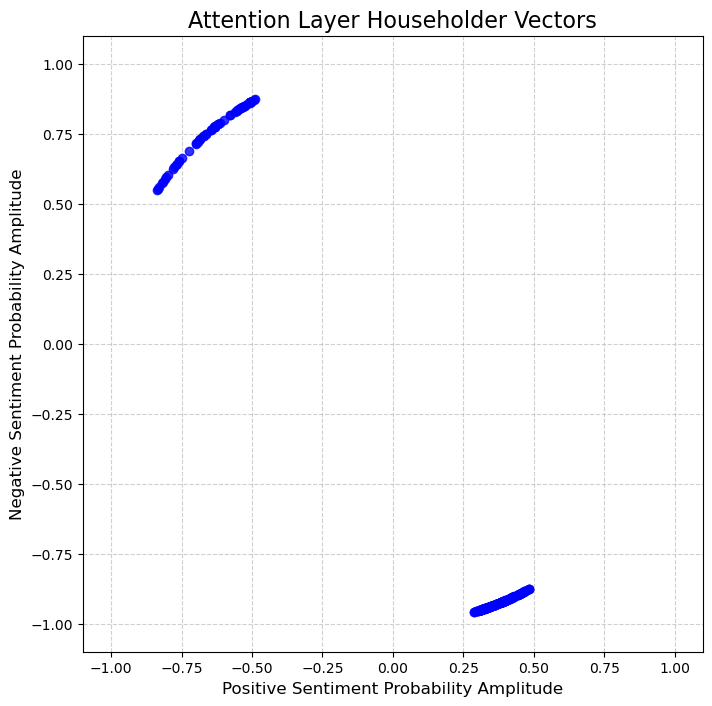

In [14]:
# Plotting attention layer Householder reflection vectors
create_vec_scatter(vec_list = attention_hh_vecs,
                  plt_title = 'Attention Layer Householder Vectors',
                  save_dir = atten_figures_dir,
                  file_name = 'attention_hh_vecs.png')

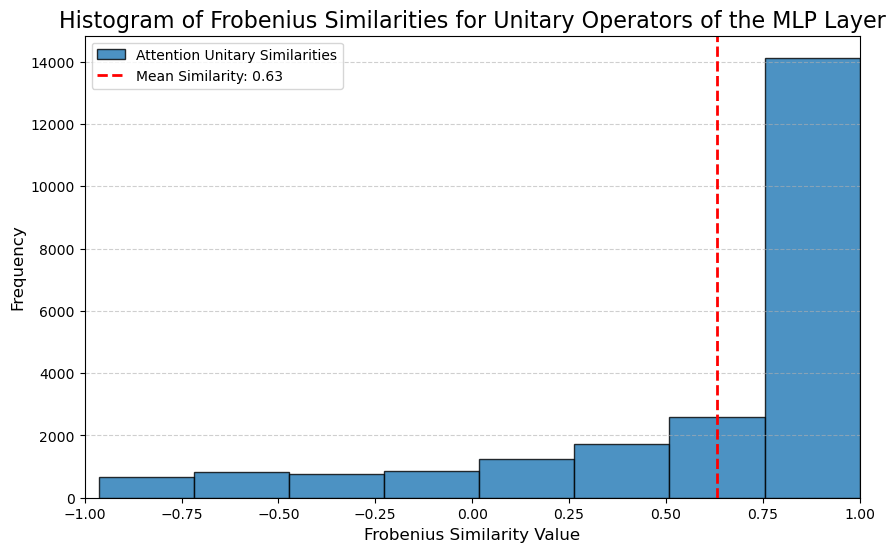

In [15]:
# Finding Frobenious cosine similarities for all operators pairs of the MLP layer
mlp_unitary_sims = get_matrix_sims(mlp_unitaries)

# Obtaining the mean similarity of the unitary operators and a creating histogram to visualize similarities
mean_mlp_unitary_sims = create_sims_histogram(sim_list = mlp_unitary_sims,
                                                    bins = 8,
                                                    plt_title = 'Histogram of Frobenius Similarities for Unitary Operators of the MLP Layer',
                                                    save_dir = mlp_figures_dir,
                                                    file_name = 'mlp_unitary_frobenius_similarities.png')

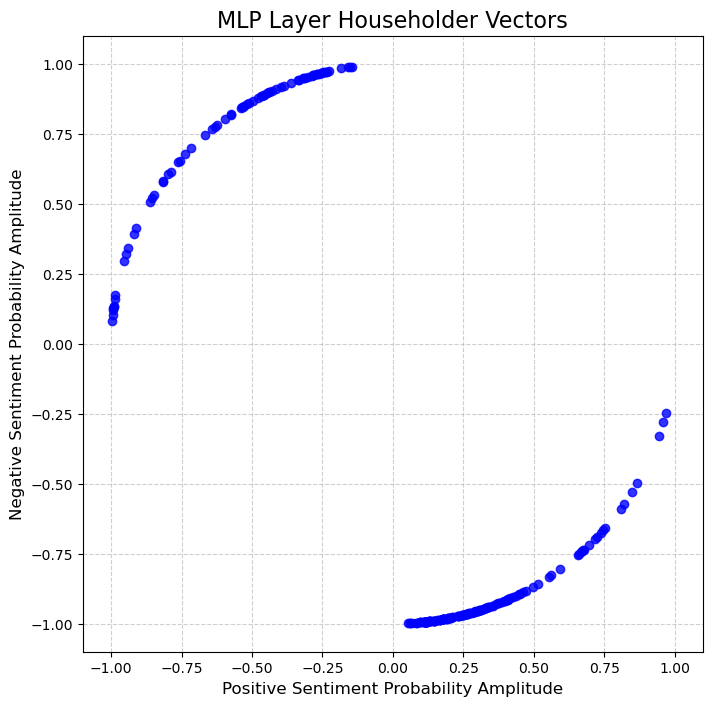

In [16]:
# Plotting MLP layer Householder reflection vectors
create_vec_scatter(vec_list = mlp_hh_vecs,
                  plt_title = 'MLP Layer Householder Vectors',
                  save_dir = mlp_figures_dir,
                  file_name = 'mlp_hh_vecs.png')

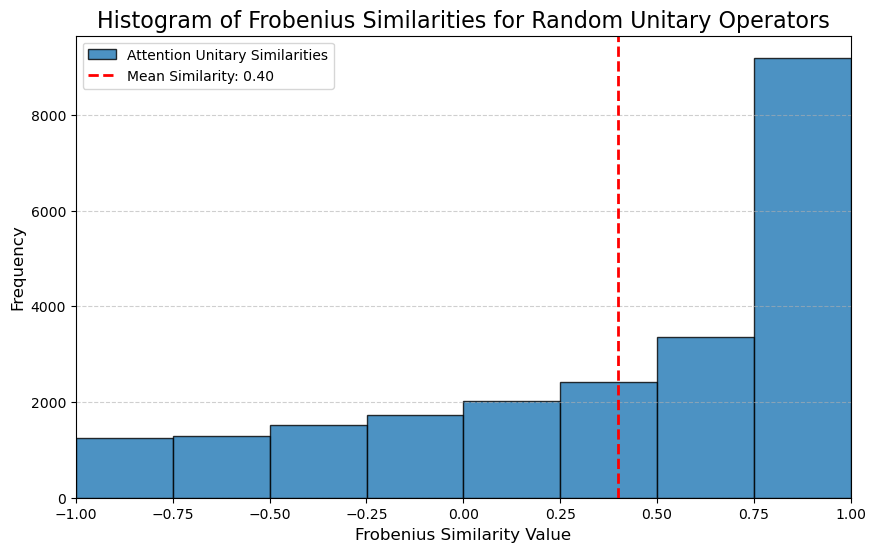

In [17]:
"""
Computing Frobenius similarities for a random set of 1070
(same as preprocessed dataset) Householder Unitaries to compare
layer-derived similaries against
"""

rand_unitaries = []

for i in range(len(unitary_dataset)):
  # Obtaining a random Householder vector to define unitary transformation
  # Householder vector is constrained to quadrants 2 and 4 as those of Transformer
  branch = np.random.randint(1, 3)
  if branch == 1:
    angle = np.random.uniform(low = 0.5 * np.pi, high = np.pi)
  else:
    angle = np.random.uniform(low = 1.5 * np.pi, high = 2 * np.pi)

  rand_hh_vec = np.array([np.cos(angle), np.sin(angle)])

  # Computing unitary from Householder vector
  rand_unitary = np.identity(2) - (2 * np.outer(rand_hh_vec, rand_hh_vec))

  rand_unitaries.append(rand_unitary)

# Finding Frobenious cosine similarities pairwise
rand_unitary_sims = get_matrix_sims(rand_unitaries)

# Obtaining the mean similarity and creating a histogram to visualize similarities
mean_rand_unitary_sims = create_sims_histogram(sim_list = rand_unitary_sims,
                                                    bins = 8,
                                                    plt_title = 'Histogram of Frobenius Similarities for Random Unitary Operators',
                                                    save_dir = figures_dir,
                                                    file_name = 'random_unitary_frobenius_similarities.png')

### Determining P-values of Frobenius Cosine Similarity Values with Permutation Tests

In [18]:
"""
flatten_and_normalize_matrices() converts a list of matricies into an np.ndarray
of row-wise flattened and normalized matricies

Args:
    matrices (list of np.ndarray): List of matricies to process

Returns:
    (np.ndarray): Flattened and L2-normalized matricies
"""

def flatten_and_normalize_matrices(matrices):

    mats = np.asarray(matrices)
    n = mats.shape[0]
    flat_mats = mats.reshape(n, -1).astype(float)  # shape (n, D)
    norms = np.linalg.norm(flat_mats, axis=1, keepdims=True)
    norms[norms == 0] = 1.0

    return flat_mats / norms

"""
mean_pairwise_frobenius_cosine() computes the mean of pairwise Frobenius
cosine similarity for a list of input matricies.

Args:
    matricies (list of np.ndarray): List of matricies to process

Returns:
    (float): The mean of pairwise Frobenius cosine similarity
"""
def mean_pairwise_frobenius_cosine(matrices):

    flat_mat = flatten_and_normalize_matrices(matrices)

    n = flat_mat.shape[0]

    # This check handles cases where the mean Frobenius cosine is undefined
    if n < 2:
        return np.nan

    # Computing similarity matrix
    sims = flat_mat @ flat_mat.T  # (n, n)

    # Taking the upper triangle of similarity matrix to avoid double counting
    valid_sims_ids = np.triu_indices(n, k=1)
    sim_vals = sims[valid_sims_ids]

    return float(np.mean(sim_vals))


"""
Permutation test that shuffles pooled matrices and recomputes group mean-pairwise-similarity.

Args:
    matricies_test (list of np.ndarray): List of matricies to be compared against baseline
    matricies_base (list of np.ndarray): Baseline list of matricies
    n_perms (int): Number of permutations
    two_sided (bool): Specifies whether to compute two-sided p-value
    seed (int): Random seed
    show_progress (bool): Specifiies whether to show a tqdm progress bar; Defult is True

Returns:
    obs_diff (float): Observed difference in mean Frobenius cosine similarities between groups
    pval (float): Empirical p-value using add-one smoothing
"""
def permutation_test_on_matrices(matricies_test, matricies_base, n_perms, two_sided, seed, show_progress=True):

    rng = np.random.default_rng(seed)

    # Pooling and computing normalized flattened rows
    mats_test = list(matricies_test)
    mats_base = list(matricies_base)
    n_test = len(mats_test)
    n_base = len(mats_base)
    pooled_mats = np.asarray(mats_test + mats_base)
    n_total = n_test + n_base
    flat_mats = flatten_and_normalize_matrices(pooled_mats)

    # Computing observed statistic (use original grouping indices 0:n_a, n_a:N)
    flat_mats_test = flat_mats[:n_test]
    flat_mats_base = flat_mats[n_test:]
    mean_a = mean_pairwise_frobenius_cosine(flat_mats_test)
    mean_b = mean_pairwise_frobenius_cosine(flat_mats_base)
    obs_diff = mean_a - mean_b

    # Permutation loop shuffles indices before computing the mean pairwise within the two groups
    perm_diffs = np.empty(n_perms, dtype=float)
    iterator = trange(n_perms) if show_progress else range(n_perms)

    for t in iterator:
        perm_idx = rng.permutation(n_total)

        idx_a = perm_idx[:n_test]
        idx_b = perm_idx[n_test:]

        flat_mats_a = flat_mats[idx_a]
        flat_mats_b = flat_mats[idx_b]

        mean_sim_a = mean_pairwise_frobenius_cosine(flat_mats_a)
        mean_sim_b = mean_pairwise_frobenius_cosine(flat_mats_b)

        perm_diffs[t] = (mean_sim_a - mean_sim_b)

    # Computing the empirical p-value with add-one smoothing
    if two_sided:
        count = np.sum(np.abs(perm_diffs) >= abs(obs_diff))
    else:
        count = np.sum(perm_diffs >= obs_diff)

    pval = (count + 1) / (n_perms + 1)

    return obs_diff, pval

In [19]:
# Permutation test for statistical significance of the similarity of the attention layer's unitary operators
attention_unitaries_obs_diff, attention_unitaries_pval = permutation_test_on_matrices(
     attention_unitaries,
     rand_unitaries,
     n_perms=1000,
     two_sided=False,
     seed=42,
     show_progress=True
)

print("Observed mean-pairwise difference in Frobenius cosine similarities (Attention Unitaries - Random Unitaries)", attention_unitaries_obs_diff)
print("Permutation test p-value:", attention_unitaries_pval)

100%|██████████| 1000/1000 [00:00<00:00, 1369.96it/s]

Observed mean-pairwise difference in Frobenius cosine similarities (Attention Unitaries - Random Unitaries) 0.49160367521898546
Permutation test p-value: 0.000999000999000999


In [20]:
# Permutation test for statistical significance of the similarity of the MLP layer's unitary operators
mlp_unitaries_obs_diff, mlp_unitaries_pval = permutation_test_on_matrices(
     mlp_unitaries,
     rand_unitaries,
     n_perms=1000,
     two_sided=False,
     seed=42,
     show_progress=True
)
print("Observed mean-pairwise difference in Frobenius cosine similarities (MLP Unitaries - Random Unitaries):", mlp_unitaries_obs_diff)
print("Permutation test p-value:", mlp_unitaries_pval)

100%|██████████| 1000/1000 [00:00<00:00, 1369.09it/s]

Observed mean-pairwise difference in Frobenius cosine similarities (MLP Unitaries - Random Unitaries): 0.23304850537249516
Permutation test p-value: 0.000999000999000999


## Deriving Hamiltonians

In [21]:
def get_hamiltonian(phi_0, phi_1, alpha):
  reflecting_plane_normal_vec = get_reflecting_plane_normal_vec(phi_0, phi_1)
  projection = np.outer(reflecting_plane_normal_vec, reflecting_plane_normal_vec)

  hamiltonian = ((np.pi) / alpha) * projection

  return hamiltonian

def get_hamiltonian_from_ex(dataset, example_id, pos_1, pos_2 = 'mlp', verbose = False, alpha = 1):

  if pos_1 == 'embedding':
    phi_0_probs = get_intermediate_probs(dataset, example_id, embedding_lens, pos_1)
    if pos_2 == 'attention':
      phi_1_probs = get_intermediate_probs(dataset, example_id, attention_lens, pos_2)
    else:
      phi_1_probs = get_final_probs(dataset, example_id)
  elif pos_1 == 'attention':
    phi_0_probs = get_intermediate_probs(dataset, example_id, attention_lens, pos_1)
    phi_1_probs = get_final_probs(dataset, example_id)

  phi_0 = construct_state_ket(phi_0_probs)
  phi_1 = construct_state_ket(phi_1_probs)

  if verbose:
    print(f"Phi_0: \n{phi_0}")
    print(f"Phi_1: \n{phi_1}")
    print("")

  hamiltonian = get_hamiltonian(phi_0, phi_1, alpha)

  return hamiltonian, phi_0, phi_1

In [22]:
attention_hamiltonians = []
mlp_hamiltonians = []

attention_io_vecs = []
mlp_io_vecs = []

hamiltonian_dataset = SentihoodDataset(X_test, y_test, tokenizer)

for i in tqdm(range(len(hamiltonian_dataset)), desc = 'Hamiltonian Construction'):

  attention_hamiltonian, attention_phi_0, attention_phi_1 = get_hamiltonian_from_ex(hamiltonian_dataset, i, 'embedding', 'attention')
  mlp_hamiltonian, mlp_phi_0, mlp_phi_1 = get_hamiltonian_from_ex(hamiltonian_dataset, i, 'attention', 'mlp')

  attention_hamiltonians.append(attention_hamiltonian)
  attention_io_vecs.append({'phi_0': attention_phi_0,
                            'phi_1': attention_phi_1})

  mlp_hamiltonians.append(mlp_hamiltonian)
  mlp_io_vecs.append({'phi_0': mlp_phi_0,
                            'phi_1': mlp_phi_1})

Hamiltonian Construction: 100%|██████████| 214/214 [00:00<00:00, 251.08it/s]


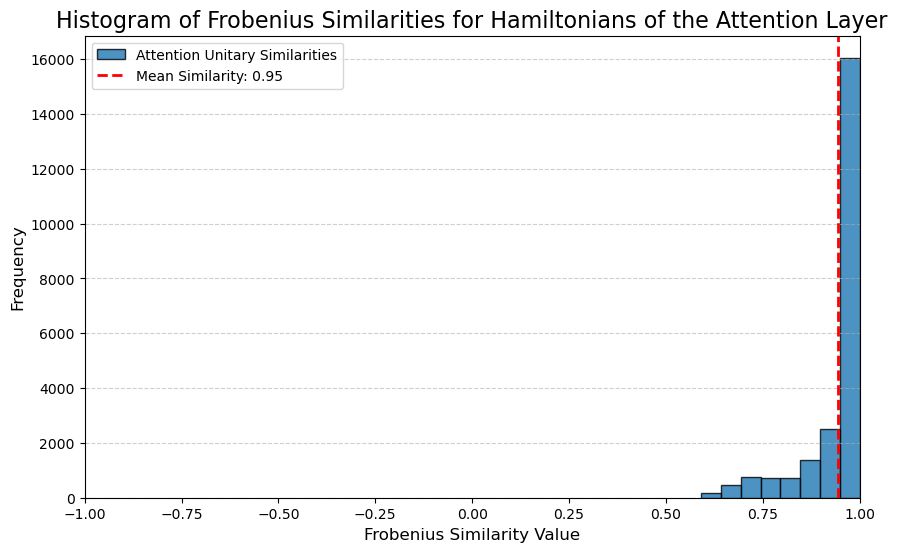

In [23]:
attention_hamiltonian_sims = get_matrix_sims(attention_hamiltonians)

# Obtaining the mean similarity of the Hamiltonians and creating a histogram to visualize similarities
mean_attention_hamiltonian_sims = create_sims_histogram(sim_list = attention_hamiltonian_sims,
                                                        bins = 8,
                                                        plt_title = 'Histogram of Frobenius Similarities for Hamiltonians of the Attention Layer',
                                                        save_dir = atten_figures_dir,
                                                        file_name = 'attention_hamiltonian_frobenius_similarities.png')

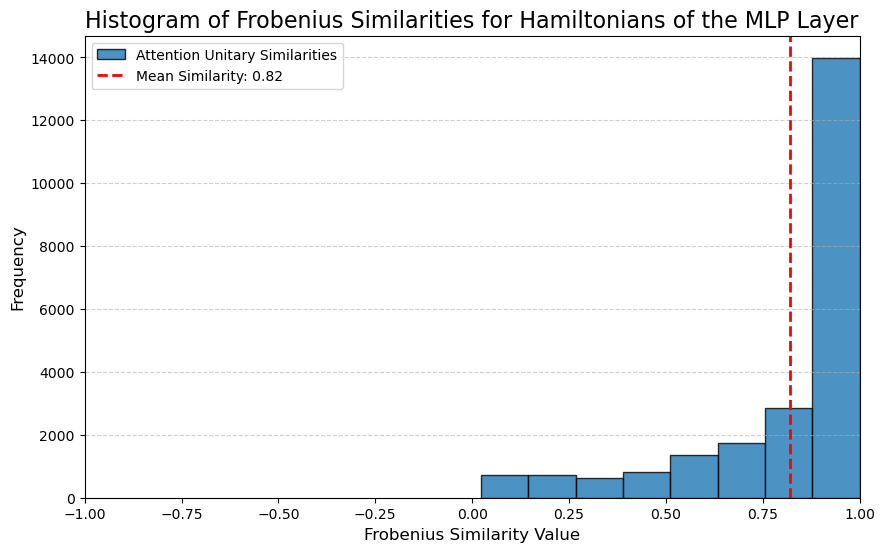

In [24]:
mlp_hamiltonian_sims = get_matrix_sims(mlp_hamiltonians)

# Obtaining the mean similarity of the Hamiltonians and creating a histogram to visualize similarities
mean_mlp_hamiltonian_sims = create_sims_histogram(sim_list = mlp_hamiltonian_sims,
                                                  bins = 8,
                                                  plt_title = 'Histogram of Frobenius Similarities for Hamiltonians of the MLP Layer',
                                                  save_dir = mlp_figures_dir,
                                                  file_name = 'mlp_hamiltonian_frobenius_similarities.png')

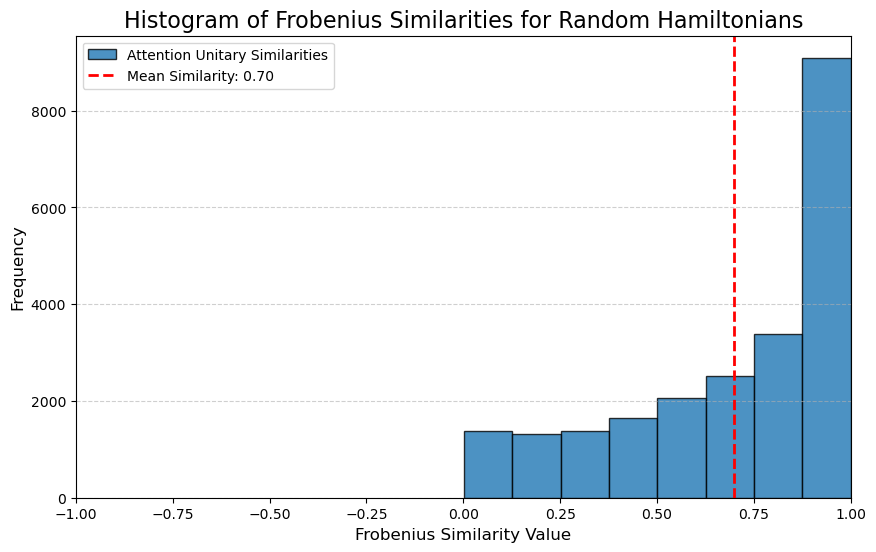

In [25]:
"""
Computing Frobenius similarities for a random set of 1070
(same as preprocessed dataset) Householder Hamiltonians to compare
layer-derived similaries against
"""

rand_hamiltonians = []

for j in range(len(unitary_dataset)):
  # Obtaining a random Householder vector to define overarching unitary transformation
  # Householder vector is constrained to quadrants 2 and 4 as those of Transformer
  branch = np.random.randint(1, 3)
  if branch == 1:
    angle = np.random.uniform(low = 0.5 * np.pi, high = np.pi)
  else:
    angle = np.random.uniform(low = 1.5 * np.pi, high = 2 * np.pi)

  rand_hh_vec = np.array([np.cos(angle), np.sin(angle)])

  # Computing Hamiltonian from Householder vector (alpha = 1)
  rand_hamiltonian = np.pi * np.outer(rand_hh_vec, rand_hh_vec)

  rand_hamiltonians.append(rand_hamiltonian)

# Finding Frobenious cosine similarities pairwise
rand_hamiltonian_sims = get_matrix_sims(rand_hamiltonians)

# Obtaining the mean similarity of the Hamiltonians and creating a histogram to visualize similarities
mean_rand_hamiltonian_sims = create_sims_histogram(sim_list = rand_hamiltonian_sims,
                                                  bins = 8,
                                                  plt_title = 'Histogram of Frobenius Similarities for Random Hamiltonians',
                                                  save_dir = figures_dir,
                                                  file_name = 'random_hamiltonian_frobenius_similarities.png')

In [26]:
# Saving computed unitaries and Hamiltonians
unitaries_and_hamiltonians = {'attention_unitaries': attention_unitaries,
                              'attention_hamiltonians': attention_hamiltonians,
                              'mlp_unitaries': mlp_unitaries,
                              'mlp_hamiltonians': mlp_hamiltonians}

with open(data_dir + "unitaries_and_hamiltonians.pkl", 'wb') as f:
  pickle.dump(unitaries_and_hamiltonians, f)

### P-value Computation

In [27]:
# Permutation test for statistical significance of the similarity of the attention hamiltonians
attention_hamiltonians_obs_diff, attention_hamiltonians_pval = permutation_test_on_matrices(
     attention_hamiltonians,
     rand_hamiltonians,
     n_perms=1000,
     two_sided=False,
     seed=42,
     show_progress=True
)

print("Observed mean-pairwise difference in Frobenius cosine similarities (Attention Hamiltonians - Random Hamiltonians)", attention_hamiltonians_obs_diff)
print("Permutation test p-value:", attention_hamiltonians_pval)

100%|██████████| 1000/1000 [00:00<00:00, 1362.39it/s]

Observed mean-pairwise difference in Frobenius cosine similarities (Attention Hamiltonians - Random Hamiltonians) 0.24780840116259717
Permutation test p-value: 0.000999000999000999


In [28]:
# Permutation test for statistical significance of the similarity of the MLP hamiltonians
mlp_hamiltonians_obs_diff, mlp_hamiltonians_pval = permutation_test_on_matrices(
     mlp_hamiltonians,
     rand_hamiltonians,
     n_perms=1000,
     two_sided=False,
     seed=42,
     show_progress=True
)

print("Observed mean-pairwise difference in Frobenius cosine similarities (Attention Hamiltonians - Random Hamiltonians)", mlp_hamiltonians_obs_diff)
print("Permutation test p-value:", mlp_hamiltonians_pval)

100%|██████████| 1000/1000 [00:00<00:00, 1347.07it/s]

Observed mean-pairwise difference in Frobenius cosine similarities (Attention Hamiltonians - Random Hamiltonians) 0.12207711291560619
Permutation test p-value: 0.000999000999000999


## Analyzing Correlation Between Model Layers

In [29]:
# Creating numpy arrays of Householder reflection vectors
attention_hh_vecs_array = np.asarray(attention_hh_vecs)
mlp_hh_vecs_array = np.asarray(mlp_hh_vecs)

In [30]:
dcor_interdependence = dcor.distance_correlation(attention_hh_vecs_array, mlp_hh_vecs_array)
print(f'Distance correlation between Attention and MLP layer Householder vectors: {dcor_interdependence:.6f}')

Distance correlation between Attention and MLP layer Householder vectors: 0.431198


In [31]:
dcor_t_test = dcor.independence.distance_correlation_t_test(attention_hh_vecs_array, mlp_hh_vecs_array)
print(f'Distance correlation t-test for independence P Value: {dcor_t_test.pvalue:.6f}')

Distance correlation t-test for independence P Value: 0.000000


In [32]:
dcor_covar_test = dcor.independence.distance_covariance_test(attention_hh_vecs_array,
                                                          mlp_hh_vecs_array,
                                                          num_resamples=1000,
                                                          random_state=42,
                                                        )
print(f'Distance correlation Covariance test for independence P Value: {dcor_covar_test.pvalue:.6f}')

Distance correlation Covariance test for independence P Value: 0.000999


## Analyzing Changes in State Vectors Derivied from the Hamiltonians

In [33]:
"""
get_delta_phi() computes change in input state vector using Hamiltonian

Args:
    phi (np.array): input state vector
    hh_vec (np.array): Householder reflection vector (eigenvector) of Hamiltonian
    hamiltonian (np.array): Layer Hamiltonain for input state vector
    alpha (float): Optional layer-dependent scaling factor

Returns:
    delta_phi (np.array): change in input state vector phi
"""
def get_delta_phi(phi, hh_vec, hamiltonian, alpha = 1):
    eigenvalue = np.dot((hamiltonian @ hh_vec), hh_vec).item()

    eignvalue_scale_factor = (cmath.exp(1j * alpha * eigenvalue) - 1)
    eignvalue_scale_factor = complex(round(eignvalue_scale_factor.real), round(eignvalue_scale_factor.imag))
    if eignvalue_scale_factor.imag == 0:
      eignvalue_scale_factor = eignvalue_scale_factor.real

    delta_phi = eignvalue_scale_factor * hh_vec * np.dot(hh_vec, phi)

    return delta_phi

In [34]:
# Computing changes in state vectors due to the attention layer across all data instances
attention_delta_phi_list = []
for i in range(len(attention_hamiltonians)):
    attention_delta_phi = get_delta_phi(attention_io_vecs[i]['phi_0'], attention_hh_vecs[i], attention_hamiltonians[i])
    attention_delta_phi_list.append(attention_delta_phi)

# Computing changes in state vectors due to the MLP layer across all data instances
mlp_delta_phi_list = []
for i in range(len(mlp_hamiltonians)):
    mlp_delta_phi = get_delta_phi(mlp_io_vecs[i]['phi_0'], mlp_hh_vecs[i], mlp_hamiltonians[i])
    mlp_delta_phi_list.append(mlp_delta_phi)

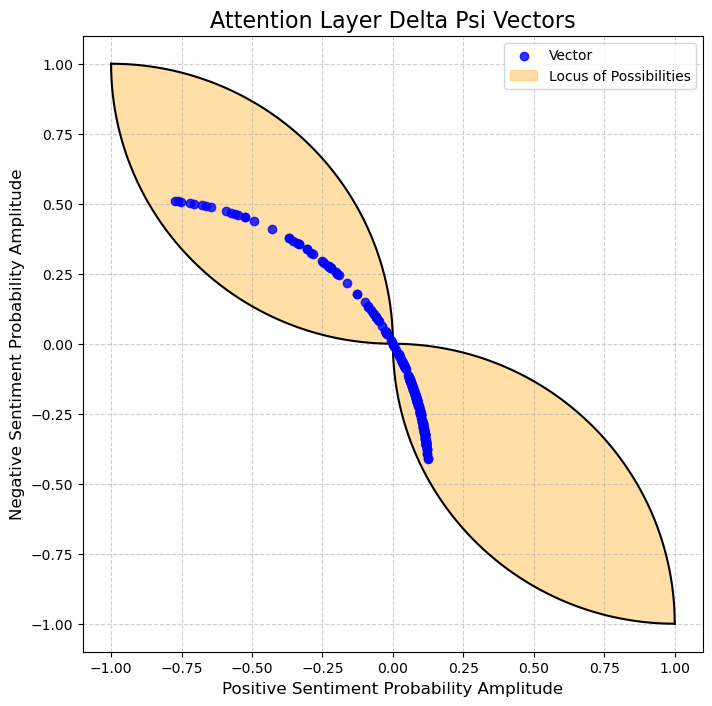

In [35]:
# Plotting changes in state vectors due to the attention layer across all data instances
create_vec_scatter(vec_list = attention_delta_phi_list,
                  plt_title = 'Attention Layer Delta Psi Vectors',
                  save_dir = atten_figures_dir,
                  file_name = 'attention_delta_psi.png',
                  delta_phi_area = True)

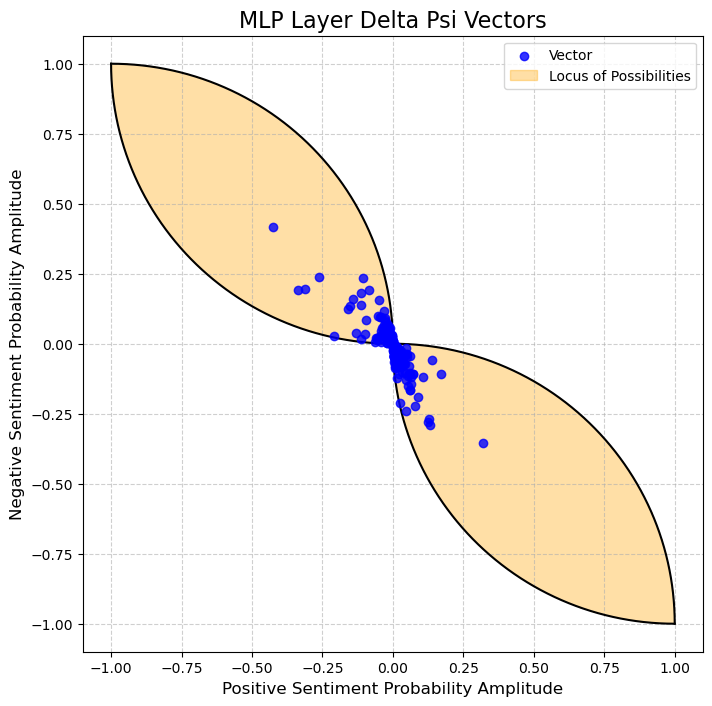

In [36]:
# Plotting changes in state vectors due to the attention layer across all data instances
create_vec_scatter(vec_list = mlp_delta_phi_list,
                  plt_title = 'MLP Layer Delta Psi Vectors',
                  save_dir = mlp_figures_dir,
                  file_name = 'mlp_delta_psi.png',
                  delta_phi_area = True)

### Average Delta Phi Norm Calculation 

In [37]:
# Computing the average change in the state vector facitilated by the attention layer
mean_attention_delta_phi = np.mean(attention_hh_vecs_array, axis = 0)
mean_attention_delta_phi_norm = np.linalg.norm(mean_attention_delta_phi)

print(f"Average change in state vector over the attention layer: {mean_attention_delta_phi}")
print(f"Magnitude of the average change in state vector over the attention layer: {mean_attention_delta_phi_norm:.3f}")

Average change in state vector over the attention layer: [ 0.06865621 -0.41388816]
Magnitude of the average change in state vector over the attention layer: 0.420


In [38]:
# Computing the average change in the state vector facitilated by the MLP layer
mean_mlp_delta_phi = np.mean(mlp_hh_vecs_array, axis = 0)
mean_mlp_delta_phi_norm = np.linalg.norm(mean_mlp_delta_phi)

print(f"Average change in state vector over the MLP layer: {mean_mlp_delta_phi}")
print(f"Magnitude of the average change in state vector over the MLP layer: {mean_mlp_delta_phi_norm:.3f}")

Average change in state vector over the MLP layer: [ 0.01414311 -0.3324105 ]
Magnitude of the average change in state vector over the MLP layer: 0.333


### Permutation Tests for the Statistical Significance of the Delta Phi Norm

In [39]:
'''
get_random_ket_vecs() randomly generates valid Householder reflection vectors through a process
similar to that used to derive the Householder reflection vectors using Tuned Lenses

Args:
    dim_vecs (int): Dimensionality of random Householder reflection vectors to generate
    num_vecs (int): Number of random Householder reflection vectors to generate

Returns:
    hh_vecs (np.ndarray): 2D array of random Householder reflection vectors
'''
def get_random_hh_vecs(dim_vecs, num_vecs):
    phi_0_vecs = np.abs(np.random.randn(num_vecs, dim_vecs))
    phi_0_vecs = phi_0_vecs / np.linalg.norm(phi_0_vecs, axis=1, keepdims=True)

    phi_1_vecs = np.abs(np.random.randn(num_vecs, dim_vecs))
    phi_1_vecs = phi_1_vecs / np.linalg.norm(phi_1_vecs, axis=1, keepdims=True)

    hh_vecs = []
    for i in range(phi_0_vecs.shape[0]):
        hh = phi_1_vecs[i, :] - phi_0_vecs[i, :]
        hh = hh / np.linalg.norm(hh)

        hh_vecs.append(hh)

    hh_vecs = np.asarray(hh_vecs)

    return hh_vecs

'''
get_random_ket_vecs() randomly generates valid state vector kets through a process
similar to that used to derive the state vectors using Tuned Lenses

Args:
    dim_vecs (int): Dimensionality of random kets to generate
    num_vecs (int): Number of random kets to generate

Returns:
    phi_0_vecs (np.ndarray): 2D array of random kets
'''
def get_random_ket_vecs(dim_vecs, num_vecs):
    phi_0_vecs = np.abs(np.random.randn(num_vecs, dim_vecs))
    phi_0_vecs = phi_0_vecs / np.linalg.norm(phi_0_vecs, axis=1, keepdims=True)

    return phi_0_vecs

'''
get_mean_delta_phi_norm() computes the magnitude of the mean vector
of the inputted 2D array of vectors

Args:
    vecs (np.ndarray): 2D array of input vectors

Returns:
    ave_vec_norm (float): Magnitude (L2 norm) of the mean vector
'''
def get_mean_vec_norm(vecs):
    ave_vec = np.mean(vecs, axis = 0)
    ave_vec_norm = np.linalg.norm(ave_vec)

    return ave_vec_norm

'''
delta_phi_norm_permutation_test() conducts a permutation test to determine the
statistical significance of the magnitude of the average input delta phi vectors
against a random baseline

Args:
    input_delta_phis (np.ndarray): 2D array of input delta phi vectors
    n_perms (int, optional): Number of permutations to run, defaults to 1000
    two_sided (bool, optional): Whether to run a two sided permutation test,
                                defaults to True
    seed (int, optional): Random seed to use, defaults to 42
    verbose (bool, optional): If True, prints the magnitude for the mean delta
                              phi vectors inputted and that for the randomized
                              baseline; defaults to False

Returns:
    obs_diff (float): Observed difference in the permutation test
    p_value (float): P-value obtained by the permutation test
'''
def delta_phi_norm_permutation_test(input_delta_phis, n_perms=1000,
                                two_sided=True, seed=42, verbose = False):
    # Initializing RNG object
    rng = np.random.default_rng(seed)

    num_vecs = input_delta_phis.shape[0]
    dim_vecs = input_delta_phis.shape[1]

    # Obtaining Random Kets, Householder, Hamiltonians, and Delta Phi Vectors
    rand_ket0_vecs = get_random_hh_vecs(dim_vecs, num_vecs)
    rand_hh_vecs = get_random_hh_vecs(dim_vecs, num_vecs)
    rand_hamiltonians = [(np.pi * np.outer(rand_hh_vecs[i, :], rand_hh_vecs[i, :])) for i in range(rand_hh_vecs.shape[0])]
    rand_delta_phi_vecs = np.asarray([get_delta_phi(rand_ket0_vecs[i, :],
                                                    rand_hh_vecs[i, :],
                                                    rand_hamiltonians[i]) for i in range(rand_hh_vecs.shape[0])])
    

    # Creating pooled array
    pooled = np.concatenate((input_delta_phis, rand_delta_phi_vecs), axis = 0)
    N, d = pooled.shape

    # Computing the observed difference
    mean_a = get_mean_vec_norm(pooled[:num_vecs, :])
    mean_b = get_mean_vec_norm(pooled[num_vecs:, :])

    if verbose:
        print('Mean Delta Phi Magnitude for Layer: ', mean_a)
        print('Mean Delta Phi Magnitude for Random Baseline: ', mean_b)

    # Computing observed difference
    obs_diff = mean_a - mean_b

    # Running permutations
    perm_diffs = np.empty(n_perms, dtype=float)
    for t in tqdm(range(n_perms), desc = 'Running Permuations'):
        perm_idx = rng.permutation(N)
        idx_a = perm_idx[:num_vecs]
        idx_b = perm_idx[num_vecs:]

        # Finding permutated norms
        norm_a = get_mean_vec_norm(pooled[idx_a, :])
        norm_b = get_mean_vec_norm(pooled[idx_b, :])

        perm_diffs[t] = norm_a - norm_b

    if two_sided:
        count = np.sum(np.abs(perm_diffs) >= abs(obs_diff))
    else:
        count = np.sum(perm_diffs >= obs_diff)

    pval = (count + 1) / (n_perms + 1) # Plus one smooting is used

    return obs_diff, pval

In [40]:
attention_delta_phi_norm_diff, attention_delta_phi_norm_p_val = delta_phi_norm_permutation_test(attention_hh_vecs_array,
                                                                                                two_sided = False,
                                                                                                verbose = True)

Mean Delta Phi Magnitude for Layer:  0.41954377861670145
Mean Delta Phi Magnitude for Random Baseline:  0.06638167309070982


Running Permuations: 100%|██████████| 1000/1000 [00:00<00:00, 25499.46it/s]


In [41]:
print(f'''Attention Delta Phi Magnitude Observed Difference: {attention_delta_phi_norm_diff:.6f}
Attention Delta Phi Magnitude P-value: {attention_delta_phi_norm_p_val:.6f}''')

Attention Delta Phi Magnitude Observed Difference: 0.353162
Attention Delta Phi Magnitude P-value: 0.000999


In [42]:
mlp_delta_phi_norm_diff, mlp_delta_phi_norm_p_val = delta_phi_norm_permutation_test(mlp_hh_vecs_array,
                                                                                    two_sided = False,
                                                                                    verbose = True)

Mean Delta Phi Magnitude for Layer:  0.33271130707298036
Mean Delta Phi Magnitude for Random Baseline:  0.12427907374161626


Running Permuations: 100%|██████████| 1000/1000 [00:00<00:00, 24784.64it/s]


In [43]:
print(f'''MLP Delta Phi Magnitude Observed Difference: {mlp_delta_phi_norm_diff:.6f}
MLP Delta Phi Magnitude P-value: {mlp_delta_phi_norm_p_val:.6f}''')

MLP Delta Phi Magnitude Observed Difference: 0.208432
MLP Delta Phi Magnitude P-value: 0.055944
